# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/drive/My Drive/final.sqlite" "final.sqlite"

In [5]:
import os
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
    
print("Preprocessed Amzon fine food data columns  shape : ",final.shape)
print("fPreprocessed Amzon fine food data columns       :",final.columns.values)

Preprocessed Amzon fine food data columns  shape :  (364171, 12)
fPreprocessed Amzon fine food data columns       : ['index' 'Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text' 'CleanedText']


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:01<00:00, 3137.37it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
final.columns

Index(['index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

preprocessed_reviews=final['CleanedText'][:100000]
score=final['Score'][:100000]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, score, test_size=0.25,stratify=score, random_state=42)



In [8]:
#BoW
count_vect = CountVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=10000) #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])

X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_bow))
print("the shape of out text BOW vectorizer ",X_test_bow.get_shape())
print("the number of unique words ", X_test_bow.get_shape()[1])

some feature names  ['ab', 'aback', 'abandon', 'abbey', 'abc', 'abdomin', 'abil', 'abl', 'abnorm', 'abomin']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (75000, 10000)
the number of unique words  10000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (25000, 10000)
the number of unique words  10000


In [0]:
#X_train_bow=X_train_bow.toarray()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_bow)
X_train_bow=scaler.transform(X_train_bow)

X_test_bow=scaler.transform(X_test_bow)

In [0]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l1')
param_grid={'C':[1000,100,10,1,0.1,0.001,0.0001]}
#timeseriessplit=TimeSeriesSplit(n_splits=10)
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_bow,y_train)
print(gcv.best_params_)
print(gcv.best_score_)



In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)

[1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.0001]
[0.9088546452748788, 0.9103610412514892, 0.912518280012368, 0.9133616781239468, 0.9157905093369368, 0.9173113487846236, 0.9236798904189109, 0.9129397282067238, 0.6950984355652179]
[0.9659050271342888, 0.9659028612935927, 0.9658948545387306, 0.9658889756573034, 0.9658521776960267, 0.9658079422705249, 0.965298273599571, 0.914513249597746, 0.695107385548616]


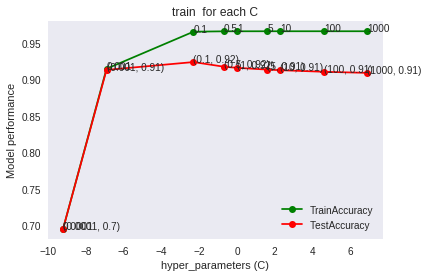

In [7]:
import math 
C =  [1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.0001]
C_log=[math.log(i) for i in C]

test_scores=[0.9088546452748788, 0.9103610412514892, 0.912518280012368, 0.9133616781239468, 0.9157905093369368, 0.9173113487846236, 0.9236798904189109, 0.9129397282067238, 0.6950984355652179]
train_scores=[0.9659050271342888, 0.9659028612935927, 0.9658948545387306, 0.9658889756573034, 0.9658521776960267, 0.9658079422705249, 0.965298273599571, 0.914513249597746, 0.695107385548616]


fig, ax = plt.subplots()
ax.plot(C_log, train_scores,c='g',marker='o',label="TrainAccuracy")

for i, txt in enumerate(C):
    ax.annotate(txt, (C_log[i], train_scores[i]))
    
ax.plot(C_log, test_scores ,c='r',marker='o',label="TestAccuracy")

for i, txt in enumerate(C):
    ax.annotate((txt,np.round(test_scores[i],2)) , (C_log[i], test_scores[i]))

plt.title("train  for each C")
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")
plt.legend()
plt.grid()
plt.show()

Accuracy Score :  90.708
Precision Score :  93.72350230414746
Recall Score :  95.48805108221043
F1 Score :  94.59754878020419
        
Classification Report
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      3701
           1       0.94      0.95      0.95     21299

   micro avg       0.91      0.91      0.91     25000
   macro avg       0.82      0.79      0.81     25000
weighted avg       0.90      0.91      0.90     25000

        
AUC Score for train data : 0.8962604569087288
AUC Score for test data : 0.7934359322551484
        


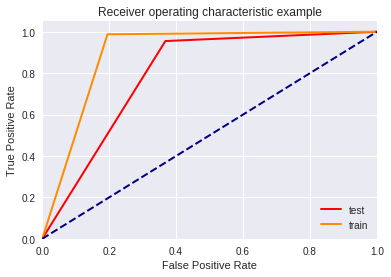

       

TrueNegative : 2339
FalsePostive : 1362
FalseNegative : 961
TruePostive  :  20338
        
        


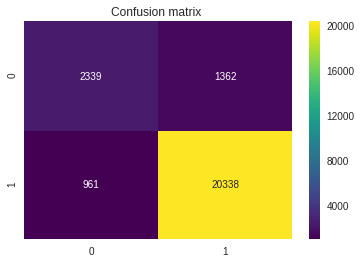

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1=LogisticRegression(C=0.1,penalty='l1')
clf1.fit(X_train_bow,y_train)
pred_train=clf1.predict(X_train_bow)
pred=clf1.predict(X_test_bow)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### with PREROCESSED REVIEWS

In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)

[1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.0001]
[0.7908377521433998, 0.8079856879597342, 0.8181680236380514, 0.8216255865348513, 0.8335232007342616, 0.8431101705158265, 0.8819334254079269, 0.5, 0.5]
[1.0, 1.0, 1.0, 1.0, 0.9999706414160041, 0.9997050308702843, 0.9880626676516027, 0.5, 0.5]


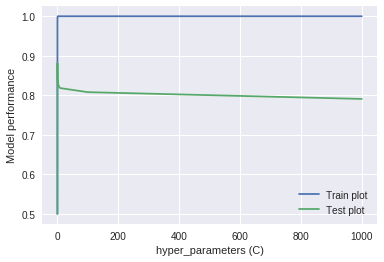

In [0]:

plt.plot( hyper_parameters ,train_scores , label='Train plot')
plt.plot( hyper_parameters ,test_scores ,  label='Test plot')
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")

plt.legend()

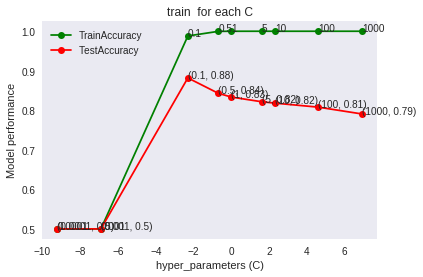

In [8]:
import math 




C = [1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.0001]
C_log=[math.log(i) for i in C]
test_scores=[0.7908377521433998, 0.8079856879597342, 0.8181680236380514, 0.8216255865348513, 0.8335232007342616, 0.8431101705158265, 0.8819334254079269, 0.5, 0.5]
train_scores = [1.0, 1.0, 1.0, 1.0, 0.9999706414160041, 0.9997050308702843, 0.9880626676516027, 0.5, 0.5]


fig, ax = plt.subplots()
ax.plot(C_log, train_scores,c='g',marker='o',label="TrainAccuracy")

for i, txt in enumerate(C):
    ax.annotate(txt, (C_log[i], train_scores[i]))
    
ax.plot(C_log, test_scores ,c='r',marker='o',label="TestAccuracy")

for i, txt in enumerate(C):
    ax.annotate((txt,np.round(test_scores[i],2)) , (C_log[i], test_scores[i]))

plt.title("train  for each C")
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")
plt.legend()
plt.grid()
plt.show()

Accuracy Score :  88.0
Precision Score :  91.07883817427386
Recall Score :  95.02164502164501
F1 Score :  93.00847457627118
        
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.51      0.58       528
           1       0.91      0.95      0.93      2772

   micro avg       0.88      0.88      0.88      3300
   macro avg       0.79      0.73      0.75      3300
weighted avg       0.87      0.88      0.87      3300

        
AUC Score for train data : 0.8778612876448715
AUC Score for test data : 0.7307900432900433
        


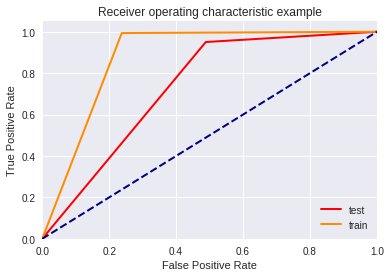

       

TrueNegative : 270
FalsePostive : 258
FalseNegative : 138
TruePostive  :  2634
        
        


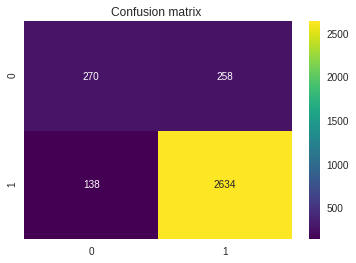

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1=LogisticRegression(C=0.1,penalty='l1')
clf1.fit(X_train_bow,y_train)
pred_train=clf1.predict(X_train_bow)
pred=clf1.predict(X_test_bow)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
a=np.count_nonzero(clf1.coef_)
size=clf1.coef_.size
Sparsity=  (size - a)/size 

In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)

[1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.0001]
[0.9088546452748788, 0.9103610412514892, 0.912518280012368, 0.9133616781239468, 0.9157905093369368, 0.9173113487846236, 0.9236798904189109, 0.9129397282067238, 0.6950984355652179]
[0.9659050271342888, 0.9659028612935927, 0.9658948545387306, 0.9658889756573034, 0.9658521776960267, 0.9658079422705249, 0.965298273599571, 0.914513249597746, 0.695107385548616]


#### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l2')
param_grid={'C':[1000,100,10,1,0.1,0.001,0.0001]}
#timeseriessplit=TimeSeriesSplit(n_splits=10)
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_bow,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'C': 0.001}
0.9097617785177461


In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)

[1000, 100, 10, 1, 0.1, 0.001, 0.0001]
[0.8511000043019294, 0.8506357843347192, 0.8536634128701011, 0.8533230213012999, 0.8600912167589186, 0.9097617785177461, 0.90257602348846]
[0.9921086446080356, 0.992160164672204, 0.9920741278201515, 0.9921541963998797, 0.9918990281685094, 0.9822747157003355, 0.9562920434285788]


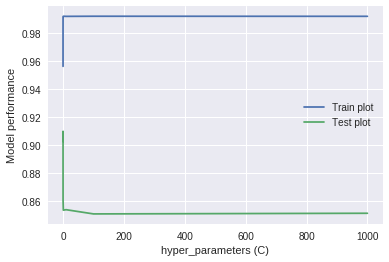

In [0]:

plt.plot( hyper_parameters ,train_scores , label='Train plot')
plt.plot( hyper_parameters ,test_scores ,  label='Test plot')
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")

plt.legend()

Accuracy Score :  91.268
Precision Score :  93.17463185472943
Recall Score :  96.84492229682145
F1 Score :  94.97433063977715
        
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.59      0.67      3701
           1       0.93      0.97      0.95     21299

   micro avg       0.91      0.91      0.91     25000
   macro avg       0.85      0.78      0.81     25000
weighted avg       0.91      0.91      0.91     25000

        
AUC Score for train data : 0.8652155813496196
AUC Score for test data : 0.7800905936510891
        


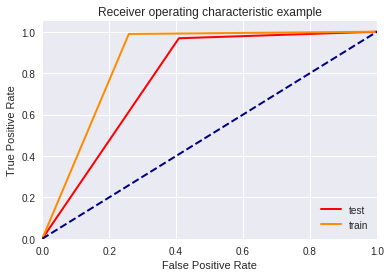

       

TrueNegative : 2190
FalsePostive : 1511
FalseNegative : 672
TruePostive  :  20627
        
        


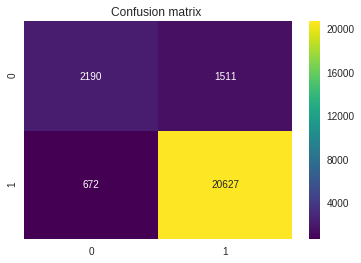

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1=LogisticRegression(C=0.001,penalty='l2')
clf1.fit(X_train_bow,y_train)
pred_train=clf1.predict(X_train_bow)
pred=clf1.predict(X_test_bow)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

##### this nosie can also be used but this gives dense matrix

In [0]:
noise=0.000001
x_train_bow_noise=np.zeros(X_train_bow.shape)
for i in range(X_train_bow.shape[0]):
    x_train_bow_noise[i]=X_train_bow[i].toarray()+noise

In [12]:
#x_train_bow_noise
from sklearn.linear_model import LogisticRegression
clfNO=LogisticRegression(C=0.001,penalty='l2')
clfNO.fit(X_train_bow,y_train)
print("WEIGHTS with X_train_bow :", clfNO.coef_[0])

WEIGHTS with X_train_bow : [ 0.00019553 -0.00740731 -0.00017604 ...  0.00757321  0.0008448
  0.00331951]


In [13]:
clfY=LogisticRegression(C=0.001,penalty='l2')
clfY.fit(x_train_noise1,y_train)
print("WEIGHTS with x_train_bow_noise  :",clfY.coef_[0])

WEIGHTS with x_train_bow_noise  : [ 0.00019553 -0.00740731 -0.00017604 ...  0.00757321  0.0008448
  0.00331951]


##### I have used this noise

In [0]:
import copy
x_train_noise1=copy.deepcopy(X_train_bow)
#e=np.random.normal(0,0.01)
x_train_noise1.data += 0.00001

In [93]:
type(x_train_noise1)

scipy.sparse.csr.csr_matrix

In [97]:
#weight without adding noise to data :::: so used X_train_bow
clfNO=LogisticRegression(C=0.001,penalty='l2')
clfNO.fit(X_train_bow,y_train)
print("weight without noise using X_train_bow : \n",clfNO.coef_[0])
print('\n')

#weight with adding noise to data :::: so used x_train_noise1
clfY=LogisticRegression(C=0.001,penalty='l2')
clfY.fit(x_train_noise1,y_train)
print("weight with noise using x_train_noise1 :\n ",clfY.coef_[0])
print('\n')

#Calculated WeightDifference
wgts_difference=(abs((clfNO.coef_[0]-clfY.coef_[0])/clfNO.coef_[0])*100)
print("weight Difference between noise and not noise :\n ",wgts_difference)
print('\n')
print("counting any weight difference greater than 0.5  : ",wgts_difference[np.where(wgts_difference > 0.5)].size)
print('\n')
print("length of Weight difference is : ",len(wgts_difference))
print('\n')
print("Weight difference is : \n",wgts_difference)

weight without noise using X_train_bow : 
 [ 0.00019553 -0.00740731 -0.00017604 ...  0.00757321  0.0008448
  0.00331951]


weight with noise using x_train_noise1 :
  [ 0.00019562 -0.00740731 -0.00017603 ...  0.00757322  0.00084479
  0.00331946]


weight Difference between noise and not noise :
  [4.87617935e-02 2.08552250e-05 4.87784215e-03 ... 1.49830512e-04
 1.28442956e-03 1.58088976e-03]


counting any weight difference greater than 0.5  :  15


length of Weight difference is :  10000


Weight difference is : 
 [4.87617935e-02 2.08552250e-05 4.87784215e-03 ... 1.49830512e-04
 1.28442956e-03 1.58088976e-03]


In [98]:
from sklearn.linear_model import LogisticRegression

#weight without adding noise to data :::: so used x_train_noise1
clf1=LogisticRegression(C=0.001,penalty='l2')
clf1.fit(X_train_bow,y_train)
pred=clf1.predict(X_test_bow)
a=np.count_nonzero(clf1.coef_)
print("AccuracyScore : ",accuracy_score(y_test,pred))
print(a)

#After getting weights adding 10**-6 to weights
#adding  W=W+10^-6 
print(clf1.coef_.shape)
wgts_without_noise=clf1.coef_[0]
print(wgts_without_noise)
wgts_without_noise=wgts_without_noise+0.000001
print(wgts_without_noise)


#x_train_noise1=copy.deepcopy(X_train_bow)
#x_train_noise1.data += 0.00001
#weight with adding noise to data :::: so used x_train_noise1
clf1_noise=LogisticRegression(C=0.001,penalty='l2')
clf1_noise.fit(x_train_noise1,y_train)
pred=clf1_noise.predict(X_test_bow)
a=np.count_nonzero(clf1_noise.coef_)
print("AccuracyScore : ",accuracy_score(y_test,pred))
print(a)

#After getting weights adding 10**-6 to weights
# adding W’ = W’+10^-6
print(clf1_noise.coef_.shape)
wgts_with_noise=clf1_noise.coef_[0]
print(wgts_with_noise)
wgts_with_noise=wgts_with_noise+0.000001
print(wgts_with_noise)


wgts_difference=(abs((wgts_without_noise-wgts_with_noise)/wgts_without_noise)*100)
print(wgts_difference[np.where(wgts_difference > 0.5)].size)
print("Weight differeemce is : ",wgts_difference)



#Calculated WeightDifference
wgts_difference=(abs((wgts_without_noise-wgts_with_noise)/wgts_without_noise)*100)
print("weight Difference between noise and not noise :\n ",wgts_difference)
print('\n')
print("counting any weight difference greater than 0.5  : ",wgts_difference[np.where(wgts_difference > 0.5)].size)
print('\n')
print("length of Weight difference is : ",len(wgts_difference))
print('\n')
print("Weight difference is : \n",wgts_difference)

AccuracyScore :  0.91268
10000
(1, 10000)
[ 0.00019553 -0.00740731 -0.00017604 ...  0.00757321  0.0008448
  0.00331951]
[ 0.00019653 -0.00740631 -0.00017504 ...  0.00757421  0.0008458
  0.00332051]
AccuracyScore :  0.91268
10000
(1, 10000)
[ 0.00019562 -0.00740731 -0.00017603 ...  0.00757322  0.00084479
  0.00331946]
[ 0.00019662 -0.00740631 -0.00017503 ...  0.00757422  0.00084579
  0.00332046]
7
Weight differeemce is :  [4.85136782e-02 2.08580409e-05 4.90570968e-03 ... 1.49810731e-04
 1.28291097e-03 1.58041367e-03]
weight Difference between noise and not noise :
  [4.85136782e-02 2.08580409e-05 4.90570968e-03 ... 1.49810731e-04
 1.28291097e-03 1.58041367e-03]


counting any weight difference greater than 0.5  :  7


length of Weight difference is :  10000


Weight difference is : 
 [4.85136782e-02 2.08580409e-05 4.90570968e-03 ... 1.49810731e-04
 1.28291097e-03 1.58041367e-03]


In [103]:
#tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
#tag_counts = tag_df_sorted['Counts'].values

wgts_difference.sort()
print(wgts_difference)

[2.95507520e-08 5.96602930e-08 7.91597000e-08 ... 9.64262480e-01
 1.43812690e+00 1.66461003e+00]


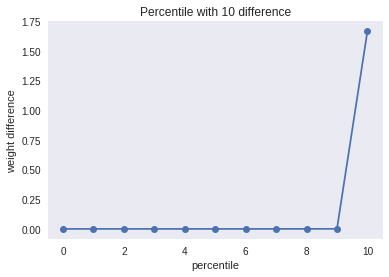

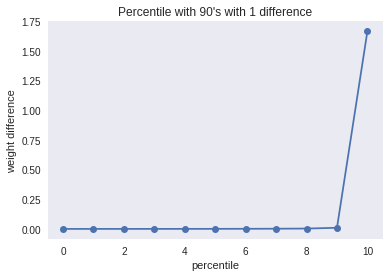

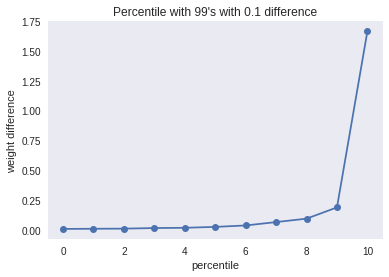

In [106]:
#wgts_difference
percentile10=np.percentile(wgts_difference, [0,10,20,30,40,50,60,70,80,90,100])
plt.plot(percentile10,'-o')
plt.title("Percentile with 10 difference")
plt.grid()
plt.xlabel("percentile")
plt.ylabel("weight difference")
plt.show()


b=np.percentile(wgts_difference,[90,91,92,93,94,95,96,97,98,99,100])
plt.plot(b,'-o')
plt.title("Percentile with 90's with 1 difference")
plt.grid()
plt.xlabel("percentile")
plt.ylabel("weight difference")
plt.show()


a=np.percentile(wgts_difference,[99,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100])
plt.plot(a,'-o')
plt.title("Percentile with 99's with 0.1 difference")
plt.grid()
plt.xlabel("percentile")
plt.ylabel("weight difference")
plt.show()

### By the above graph sudden rise at 99.9 percentile

### Another way of plotting percentiles

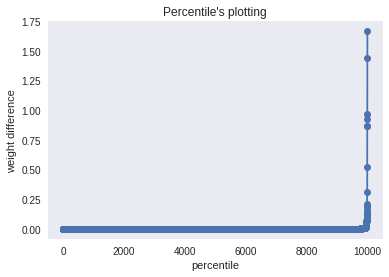

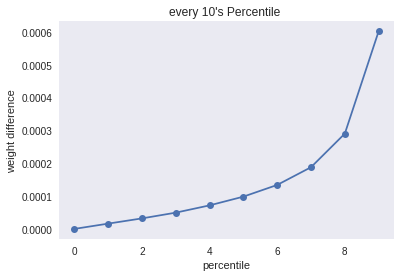

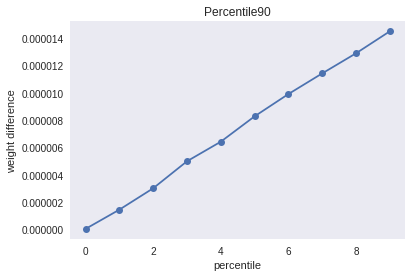

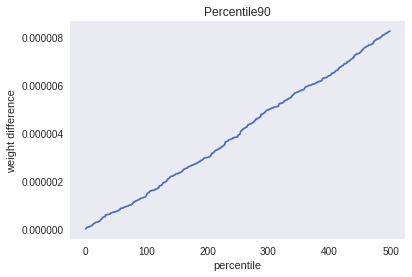

In [107]:
plt.plot(wgts_difference,'-o')
plt.title("Percentile's plotting")
plt.grid()
plt.xlabel("percentile")
plt.ylabel("weight difference")
plt.show()


plt.plot(wgts_difference[0:10000:1000],'-o')
plt.title("every 10's Percentile ")
plt.grid()
plt.xlabel("percentile")
plt.ylabel("weight difference")
plt.show()

plt.plot(wgts_difference[0:1000:100],'-o')
plt.title("Percentile90")
plt.grid()
plt.xlabel("percentile")
plt.ylabel("weight difference")
plt.show()


plt.plot(wgts_difference[0:500])
plt.title("Percentile90")
plt.grid()
plt.xlabel("percentile")
plt.ylabel("weight difference")
plt.show()



plt.plot(wgts_difference[0:10000], c='b')
plt.scatter(x=list(range(0,10000,2500)), y=wgts_difference[0:10000:2500], c='red', label="quantiles with 0.25 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,10000,1000)), y=wgts_difference[0:10000:1000], c='m', label = "quantiles with 0.05 intervals")
#for x,y in zip(list(range(0,100,25)), wgts_difference[0:100:25]):
#    plt.annotate(s="({} , {})".format(x,y), xy=(x,y))


plt.plot(wgts_difference[0:5000], c='b')
plt.scatter(x=list(range(0,5000,1250)), y=wgts_difference[0:5000:1250], c='red', label="quantiles with 0.25 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,5000,1250)), y=wgts_difference[0:5000:1250], c='m', label = "quantiles with 0.05 intervals")
#for x,y in zip(list(range(0,100,25)), wgts_difference[0:100:25]):
#    plt.annotate(s="({} , {})".format(x,y), xy=(x,y)

In [113]:
wgts_difference.sort()
wgts_difference[0:len(wgts_difference):1000]

array([2.95507520e-08, 1.61335340e-05, 3.20651557e-05, 4.95881036e-05,
       7.17487326e-05, 9.83537415e-05, 1.34006676e-04, 1.87983163e-04,
       2.90350526e-04, 6.02159641e-04])

<class 'numpy.ndarray'>


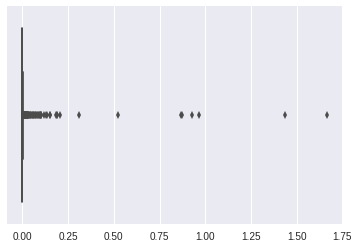

10000

In [114]:
print(type(wgts_difference))
sns.boxplot(wgts_difference)
plt.show()

from numpy import percentile
val= percentile(wgts_difference,[25,50,75])
val

np.sort(wgts_difference).size

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [115]:
feature_names=count_vect.get_feature_names()
coefs=sorted(zip(clf1.coef_[0],feature_names))

top20Negative=coefs[:20]
top20Postive=coefs[::-1][:20]

res_neg=pd.DataFrame(top20Negative,columns=['Features','Values'])
res_pos=pd.DataFrame(top20Postive,columns=['Features','Values'])
pd.concat([res_neg,res_pos],axis=1)


,Features,Values,Features,Values
0,-0.261300,disappoint,0.497705,great
1,-0.182547,worst,0.425680,love
2,-0.163124,return,0.372925,best
3,-0.155267,terribl,0.295090,delici
4,-0.150823,thought,0.276514,good
5,-0.148989,aw,0.241148,excel
6,-0.148580,money,0.236529,perfect
7,-0.139838,horribl,0.220495,favorit
8,-0.136285,unfortun,0.214225,nice
9,-0.126837,threw,0.166982,wonder


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df=0.95,stop_words='english',max_features=50000 )
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf= tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])

X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_tfidf))
print("the shape of out text TFIDF vectorizer ",X_test_tfidf.get_shape())
print("the number of unique words ", X_test_tfidf.get_shape()[1])


some sample features(unique words in the corpus) ['aback', 'abandon', 'abc', 'abdomin', 'abil', 'abl', 'abl amazon', 'abl ani', 'abl anywher', 'abl break']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (75000, 38379)
the number of unique words including both unigrams and bigrams  38379
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (25000, 38379)
the number of unique words  38379


In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_tfidf)
X_train_tfidf=scaler.transform(X_train_tfidf)

X_test_tfidf=scaler.transform(X_test_tfidf)

In [0]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l1')
param_grid={'C':[1000,100,10,1,0.1,0.001,0.0001]}
#timeseriessplit=TimeSeriesSplit(n_splits=10)
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_tfidf,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'C': 0.1}
0.9292712996949454


[1000, 100, 10, 1, 0.1, 0.001, 0.0001]
[0.8909053304983988, 0.9016360483725683, 0.9178976054051204, 0.9222105100849963, 0.9292712996949454, 0.8672104253999816, 0.5]
[1.0, 1.0, 1.0, 1.0, 0.999998432394815, 0.8695069653061985, 0.5]


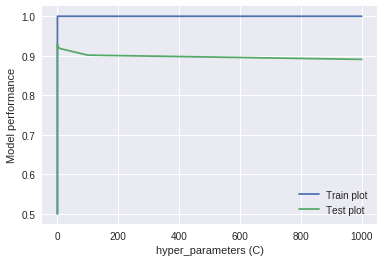

In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)


plt.plot( hyper_parameters ,train_scores , label='Train plot')
plt.plot( hyper_parameters ,test_scores ,  label='Test plot')
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")

plt.legend()

Accuracy Score :  91.444
Precision Score :  94.64103278536268
Recall Score :  95.38965597940557
F1 Score :  95.01386978717453
        
Classification Report
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      3635
           1       0.95      0.95      0.95     21365

   micro avg       0.91      0.91      0.91     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.91      0.91      0.91     25000

        
AUC Score for train data : 0.9995970630372493
AUC Score for test data : 0.8182137544499852
        


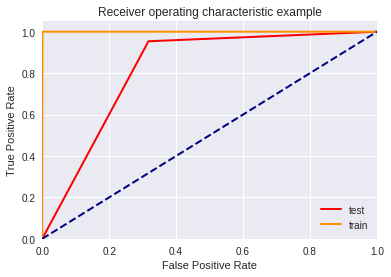

       

TrueNegative : 2481
FalsePostive : 1154
FalseNegative : 985
TruePostive  :  20380
        
        


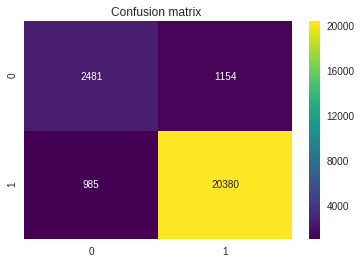

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1=LogisticRegression(C=0.1,penalty='l1')
clf1.fit(X_train_tfidf,y_train)
pred_train=clf1.predict(X_train_tfidf)
pred=clf1.predict(X_test_tfidf)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l2')
param_grid={'C':[1000,100,10,1,0.1,0.001,0.0001]}
#timeseriessplit=TimeSeriesSplit(n_splits=10)
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_tfidf,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'C': 0.0001}
0.9386103426546142


[1000, 100, 10, 1, 0.1, 0.001, 0.0001]
[0.9048738818353523, 0.9049524106876847, 0.904967451186365, 0.9066315452519695, 0.9098220252645793, 0.926345752661734, 0.9386103426546142]
[1.0, 1.0, 1.0, 1.0, 1.0, 0.9999967420917926, 0.9978873148839904]


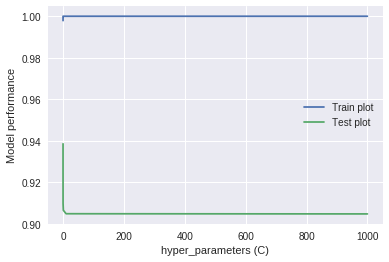

In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)


plt.plot( hyper_parameters ,train_scores , label='Train plot')
plt.plot( hyper_parameters ,test_scores ,  label='Test plot')
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")

plt.legend()


Accuracy Score :  91.776
Precision Score :  92.6831424908263
Recall Score :  98.12309852562603
F1 Score :  95.32557293561294
        
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.54      0.66      3635
           1       0.93      0.98      0.95     21365

   micro avg       0.92      0.92      0.92     25000
   macro avg       0.88      0.76      0.81     25000
weighted avg       0.91      0.92      0.91     25000

        
AUC Score for train data : 0.9125294110148021
AUC Score for test data : 0.7629676246776487
        


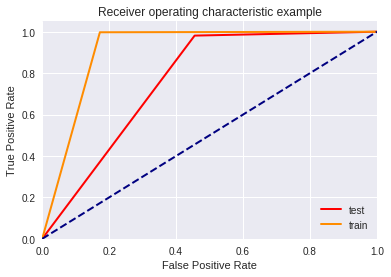

       

TrueNegative : 1980
FalsePostive : 1655
FalseNegative : 401
TruePostive  :  20964
        
        


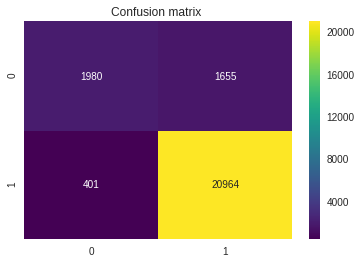

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1=LogisticRegression(C=0.0001,penalty='l2')
clf1.fit(X_train_tfidf,y_train)
pred_train=clf1.predict(X_train_tfidf)
pred=clf1.predict(X_test_tfidf)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()








### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
feature_names=tf_idf_vect.get_feature_names()
coefs=sorted(zip(clf1.coef_[0],feature_names))

top20Negative=coefs[:20]
top20Postive=coefs[::-1][:20]

res_neg=pd.DataFrame(top20Negative,columns=['Features','Values'])
res_pos=pd.DataFrame(top20Postive,columns=['Features','Values'])
pd.concat([res_neg,res_pos],axis=1)

,Features,Values,Features,Values
0,-0.071519,disappoint,0.122651,great
1,-0.067153,veri disappoint,0.121623,love
2,-0.060787,worst,0.094357,best
3,-0.051640,terribl,0.080949,good
4,-0.050525,aw,0.075217,delici
5,-0.047269,return,0.059922,perfect
6,-0.045456,horribl,0.059878,excel
7,-0.042103,threw,0.058697,favorit
8,-0.041307,wors,0.052519,nice
9,-0.041176,wont buy,0.052321,use


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())
	
	
#*******************************************************************************************

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
		
#*******************************************************************************************

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

#*******************************************************************************************


# average Word2Vec
# compute average word2vec for each review.
X_train_AvgW2V_100000 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_AvgW2V_100000.append(sent_vec)
print(len(X_train_AvgW2V_100000))
print(len(X_train_AvgW2V_100000[0]))



  0%|          | 92/75000 [00:00<01:21, 915.01it/s]

[('terrif', 0.8637382388114929), ('awesom', 0.8417178392410278), ('excel', 0.8403081297874451), ('wonder', 0.8175906538963318), ('fantast', 0.8126950263977051), ('good', 0.8095090389251709), ('perfect', 0.8006742596626282), ('fabul', 0.7345156669616699), ('decent', 0.709589958190918), ('nice', 0.6975454688072205)]
[('greatest', 0.7696366310119629), ('best', 0.7653523087501526), ('tastiest', 0.6937639713287354), ('nicest', 0.6832467913627625), ('closest', 0.6737667918205261), ('disgust', 0.6405009627342224), ('nastiest', 0.6355428695678711), ('hottest', 0.5996732115745544), ('finest', 0.5870007872581482), ('horribl', 0.5557085275650024)]
number of words that occured minimum 5 times  11759
sample words  ['order', 'this', 'the', 'tastiest', 'oatmeal', 'have', 'ever', 'eaten', 'far', 'superior', 'organ', 'been', 'purchas', 'natur', 'section', 'local', 'groceri', 'store', 'better', 'flavor', 'and', 'textur', 'also', 'servic', 'was', 'great', 'summertim', 'has', 'gone', 'but', 'product', 'st

100%|██████████| 75000/75000 [02:07<00:00, 589.43it/s]

75000
50


In [0]:
import pickle
with open('X_train_AvgW2V.pkl', 'wb') as f:
  pickle.dump(X_train_AvgW2V, f)

In [0]:
import pickle
with open('X_train_AvgW2V_100000.pkl', 'wb') as f:
  pickle.dump(X_train_AvgW2V_100000, f)

In [0]:
#*********************************************************************************************

i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
	
#*******************************************************************************************


# average Word2Vec
# compute average word2vec for each review.
X_test_AvgW2V_100000 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_AvgW2V_100000.append(sent_vec)
print(len(X_test_AvgW2V_100000))
print(len(X_test_AvgW2V_100000[0]))

100%|██████████| 25000/25000 [00:43<00:00, 579.18it/s]

25000
50


In [0]:
from google.colab import files
files.download('X_train_AvgW2V_100000.pkl')

In [0]:
import pickle
with open('X_test_AvgW2V_100000.pkl', 'wb') as f:
  pickle.dump(X_test_AvgW2V_100000, f)

In [0]:
from google.colab import files
files.download('X_test_AvgW2V_100000.pkl')

In [0]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_AvgW2V_100000)
X_train_AvgW2V=scaler.transform(X_train_AvgW2V_100000)

X_test_AvgW2V=scaler.transform(X_test_AvgW2V_100000)


In [0]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l1')
param_grid={'C':[1000,100,10,5,1,0.5,0.1,0.001,0.0001]}
#timeseriessplit=TimeSeriesSplit(n_splits=10)
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_AvgW2V,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'C': 0.1}
0.9007299333163759


[1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.0001]
[0.9007167027794262, 0.9007180144130086, 0.9007181265108707, 0.9007192835458553, 0.9007202587848292, 0.9007170469938147, 0.9007299333163759, 0.8782740824196674, 0.6711832154829824]
[0.9014580585714148, 0.9014582111242412, 0.9014587867253511, 0.9014594021766745, 0.9014579165038056, 0.9014517503699985, 0.901458403119588, 0.8788911387273874, 0.6712408567467387]


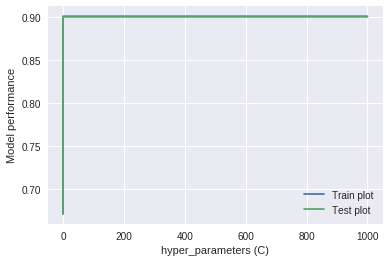

In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)


plt.plot( hyper_parameters ,train_scores , label='Train plot')
plt.plot( hyper_parameters ,test_scores ,  label='Test plot')
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")

plt.legend()

Accuracy Score :  88.74
Precision Score :  90.73699929725932
Recall Score :  96.69553007254856
F1 Score :  93.6215530328779
        
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.42      0.52      3635
           1       0.91      0.97      0.94     21365

   micro avg       0.89      0.89      0.89     25000
   macro avg       0.80      0.69      0.73     25000
weighted avg       0.87      0.89      0.88     25000

        
AUC Score for train data : 0.6994174199573306
AUC Score for test data : 0.6933813642554526
        


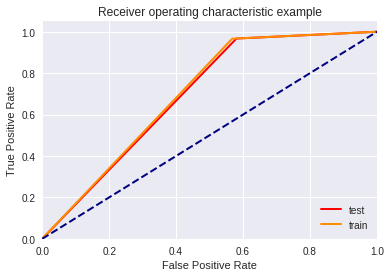

       

TrueNegative : 1526
FalsePostive : 2109
FalseNegative : 706
TruePostive  :  20659
        
        


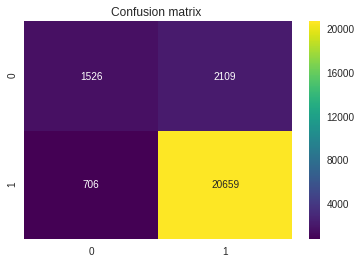

In [0]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1=LogisticRegression(C=0.1,penalty='l1')
clf1.fit(X_train_AvgW2V,y_train)
pred_train=clf1.predict(X_train_AvgW2V)
pred=clf1.predict(X_test_AvgW2V)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()




### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l2')
param_grid={'C':[1000,100,10,5,1,0.5,0.1,0.001,0.0001]}
#timeseriessplit=TimeSeriesSplit(n_splits=10)
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_AvgW2V,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'C': 0.1}
0.9007230793376875


[1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.0001]
[0.9007046960046837, 0.9007049624469834, 0.9007073262931394, 0.9007083569485211, 0.9007160648083817, 0.9007200974046736, 0.9007230793376875, 0.8988671134516509, 0.882827981371257]
[0.9014466984609755, 0.901446754567538, 0.9014495941602446, 0.9014495135941442, 0.9014572699788624, 0.9014608961262898, 0.9014580909601155, 0.8994398345547424, 0.8832301217866835]


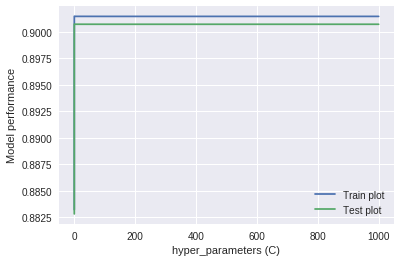

In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)


plt.plot( hyper_parameters ,train_scores , label='Train plot')
plt.plot( hyper_parameters ,test_scores ,  label='Test plot')
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")

plt.legend()

Accuracy Score :  88.764
Precision Score :  90.77883263009845
Recall Score :  96.6721273110227
F1 Score :  93.63283994831923
        
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.42      0.52      3635
           1       0.91      0.97      0.94     21365

   micro avg       0.89      0.89      0.89     25000
   macro avg       0.80      0.69      0.73     25000
weighted avg       0.88      0.89      0.88     25000

        
AUC Score for train data : 0.7005523554218793
AUC Score for test data : 0.6947774178480983
        


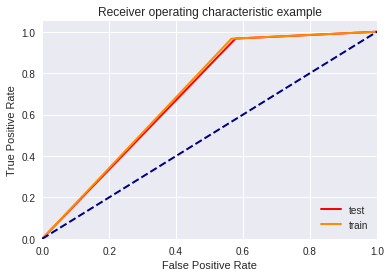

       

TrueNegative : 1537
FalsePostive : 2098
FalseNegative : 711
TruePostive  :  20654
        
        


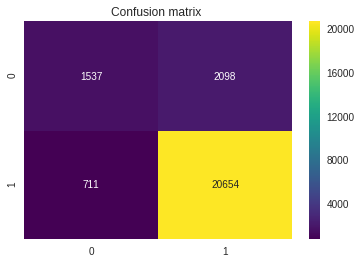

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1=LogisticRegression(C=0.1,penalty='l2')
clf1.fit(X_train_AvgW2V,y_train)
pred_train=clf1.predict(X_train_AvgW2V)
pred=clf1.predict(X_test_AvgW2V)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()




## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_df=0.95,stop_words='english',max_features=5000 )
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

#*********************************************************************************************

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_Avgtfidf_100000 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_Avgtfidf_100000.append(sent_vec)
    row += 1



In [0]:
#*********************************************************************************************

X_test_Avgtfidf_100000 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_Avgtfidf_100000.append(sent_vec)
    row += 1




  3%|▎         | 831/25000 [00:37<03:33, 113.03it/s]

In [0]:
import pickle
with open('X_train_Avgtfidf_100000.pkl', 'wb') as f:
  pickle.dump(X_train_Avgtfidf_100000, f)

In [0]:
import pickle
with open('X_test_Avgtfidf_100000.pkl', 'wb') as f:
  pickle.dump(X_test_Avgtfidf_100000, f)

In [0]:
from google.colab import files
files.download('X_train_Avgtfidf_100000.pkl')

In [0]:
from google.colab import files
files.download('X_test_Avgtfidf_100000.pkl')

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(X_train_Avgtfidf_100000)
X_train_Avgtfidf=scaler.transform(X_train_Avgtfidf_100000)

X_test_Avgtfidf=scaler.transform(X_test_Avgtfidf_100000)

In [0]:
print(X_train_Avgtfidf.shape,len(y_train),X_test_Avgtfidf.shape,len(y_test))

(75000, 50) 75000 (25000, 50) 25000


In [0]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l1')
param_grid={'C':[1000,100,10,5,1,0.5,0.1,0.001,0.0001]}
#timeseriessplit=TimeSeriesSplit(n_splits=10)
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_Avgtfidf,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'C': 0.5}
0.8634936283951694


[1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.0001]
[0.8634130341529095, 0.8634134832056587, 0.8634180844298626, 0.8634218302513165, 0.8634629300248184, 0.8634936283951694, 0.8634162350503543, 0.8152802608557099, 0.6386246100716295]
[0.8646048120674523, 0.8646051951826704, 0.8646106962769953, 0.8646133587574667, 0.8646545997067424, 0.8646792115276515, 0.8645850224511005, 0.8160322620536167, 0.6386806669634713]


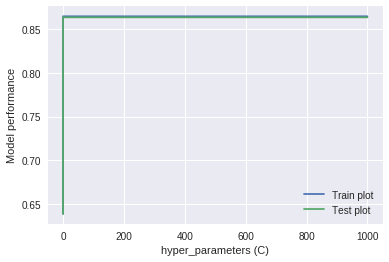

In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)


plt.plot( hyper_parameters ,train_scores , label='Train plot')
plt.plot( hyper_parameters ,test_scores ,  label='Test plot')
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")

plt.legend()

Accuracy Score :  87.52799999999999
Precision Score :  89.2898669307954
Recall Score :  97.04657149543647
F1 Score :  93.00677342663617
        
Classification Report
              precision    recall  f1-score   support

           0       0.65      0.32      0.42      3635
           1       0.89      0.97      0.93     21365

   micro avg       0.88      0.88      0.88     25000
   macro avg       0.77      0.64      0.68     25000
weighted avg       0.86      0.88      0.86     25000

        
AUC Score for train data : 0.6485271285189526
AUC Score for test data : 0.6431420734331659
        


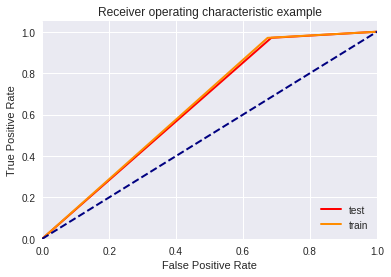

       

TrueNegative : 1148
FalsePostive : 2487
FalseNegative : 631
TruePostive  :  20734
        
        


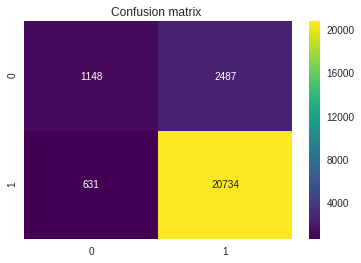

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1=LogisticRegression(C=0.5,penalty='l1')
clf1.fit(X_train_Avgtfidf,y_train)
pred_train=clf1.predict(X_train_Avgtfidf)
pred=clf1.predict(X_test_Avgtfidf)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()




### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
from sklearn.linear_model import LogisticRegression

clf=LogisticRegression(penalty='l2')
param_grid={'C':[1000,100,10,5,1,0.5,0.1,0.001,0.0001]}
#timeseriessplit=TimeSeriesSplit(n_splits=10)
gcv=GridSearchCV(clf,param_grid,cv=5,scoring='roc_auc')
gcv.fit(X_train_Avgtfidf,y_train)
print(gcv.best_params_)
print(gcv.best_score_)

{'C': 0.1}
0.8635213967923081


[1000, 100, 10, 5, 1, 0.5, 0.1, 0.001, 0.0001]
[0.8633956265099353, 0.8633952826912352, 0.8634009355048974, 0.863409856826655, 0.8634449191924536, 0.8634786199808072, 0.8635213967923081, 0.8592823633143652, 0.8240068507338287]
[0.8645871843553113, 0.8645869507616778, 0.8645923646056921, 0.8645995591362844, 0.8646347196807469, 0.8646650113597101, 0.8646980758164574, 0.8602040061553147, 0.8245984473005616]


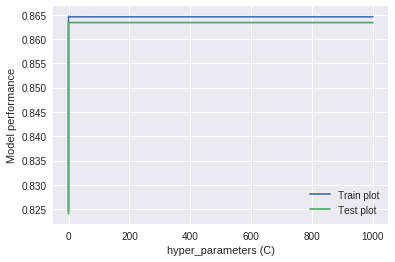

In [0]:
hyper_parameters=gcv.get_params()['param_grid']['C']
train_scores=gcv.cv_results_['mean_train_score'].tolist()
test_scores=gcv.cv_results_['mean_test_score'].tolist()

print(hyper_parameters)
print(test_scores)
print(train_scores)


plt.plot( hyper_parameters ,train_scores , label='Train plot')
plt.plot( hyper_parameters ,test_scores ,  label='Test plot')
plt.xlabel("hyper_parameters (C)")
plt.ylabel("Model performance")

plt.legend()

Accuracy Score :  87.53999999999999
Precision Score :  89.2946343984153
Recall Score :  97.0559326000468
F1 Score :  93.0136586897526
        
Classification Report
              precision    recall  f1-score   support

           0       0.65      0.32      0.42      3635
           1       0.89      0.97      0.93     21365

   micro avg       0.88      0.88      0.88     25000
   macro avg       0.77      0.64      0.68     25000
weighted avg       0.86      0.88      0.86     25000

        
AUC Score for train data : 0.6477156491287481
AUC Score for test data : 0.6433264305380608
        


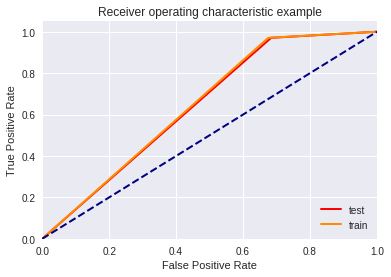

       

TrueNegative : 1149
FalsePostive : 2486
FalseNegative : 629
TruePostive  :  20736
        
        


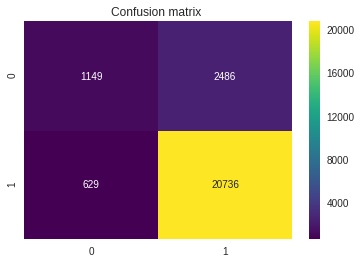

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
 


clf1=LogisticRegression(C=0.1,penalty='l2')
clf1.fit(X_train_Avgtfidf,y_train)
pred_train=clf1.predict(X_train_Avgtfidf)
pred=clf1.predict(X_test_Avgtfidf)

print("Accuracy Score : ",accuracy_score(y_test,pred)*100)
print("Precision Score : ",precision_score(y_test,pred)*100)
print("Recall Score : ",recall_score(y_test,pred)*100)
print("F1 Score : ",f1_score(y_test,pred)*100)

print("        ")  
print("Classification Report")
print(classification_report(y_test,pred))
print("        ")  

fpr_train,tpr_train,thresholds_train=roc_curve(y_train,pred_train)
print("AUC Score for train data :",metrics.auc(fpr_train,tpr_train))

fpr,tpr,thresholds=roc_curve(y_test,pred)
print("AUC Score for test data :",metrics.auc(fpr,tpr))

print("        ")  

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
#skplt.metrics.plot_roc_curve(y_true, y_probas)
#plt.show()



plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw,label='test')
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw,label='train')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


print("       ")

tn, fp, fn, tp=confusion_matrix(y_test,pred).ravel()
print("""
TrueNegative : {}
FalsePostive : {}
FalseNegative : {}
TruePostive  :  {}""".format(tn, fp, fn, tp))
print("        ")  
print("        ")  

confusionmatrix_DF=pd.DataFrame(confusion_matrix(y_test,pred),columns=['0','1'],index=['0','1'])
sns.heatmap(confusionmatrix_DF,annot=True,fmt='g',cmap='viridis')
plt.title("Confusion matrix ")
plt.show()




# [6] Conclusions

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["LogisticRegression with Different Vectorization","penalty" , "C-value" , 'Test_Accuracy','F1-Score','AUC_Score']


x.add_row([ "LR with BOW" , "l1" , 0.1  , 90.708  ,  94.59 ,79.34  ])
x.add_row([ "LR with BOW without Standardization" , "l1" , 0.1  , 88.0  ,  93.00 , 73.07 ])

x.add_row([ "LR with BOW" , "l2" , 0.001  , 91.268 ,94.974,  78.00 ])
x.add_row([ "LR with TFIDF" , "l1" ,0.1 , 91.444  ,  95.013 ,81.821 ])
x.add_row([ "LR with TFIDF" , "l2" , 0.0001  , 91.776  ,  95.322,76.296 ])

x.add_row([ "LR with AVG_W2V" , "l1" , 0.1, 88.74 ,  93.62 ,69.338  ])
x.add_row([ "LR with AVG_W2V" , "l2" , 0.1  , 88.764 ,  93.632,69.477])
x.add_row([ "LR with AVG_TFIDF" , "l1" , 0.5 , 87.527 , 93.000, 64.314])
x.add_row([ "LR with AVG_TFIDF" , "l2" ,0.1, 87.539 ,  93.013 , 64.33  ])




print(x)

+-------------------------------------------------+---------+---------+---------------+----------+-----------+
| LogisticRegression with Different Vectorization | penalty | C-value | Test_Accuracy | F1-Score | AUC_Score |
+-------------------------------------------------+---------+---------+---------------+----------+-----------+
|                   LR with BOW                   |    l1   |   0.1   |     90.708    |  94.59   |   79.34   |
|       LR with BOW without Standardization       |    l1   |   0.1   |      88.0     |   93.0   |   73.07   |
|                   LR with BOW                   |    l2   |  0.001  |     91.268    |  94.974  |    78.0   |
|                  LR with TFIDF                  |    l1   |   0.1   |     91.444    |  95.013  |   81.821  |
|                  LR with TFIDF                  |    l2   |  0.0001 |     91.776    |  95.322  |   76.296  |
|                 LR with AVG_W2V                 |    l1   |   0.1   |     88.74     |  93.62   |   69.338  |
|

##Summy:
* Have Applied LR with All vectors and with voth penalty ie l1 and l2
* Among all vectorizatiob TFIDF with penalty l1 gives high accuracy
*  Done LR with Standardization Data and without Standardization Data what i have observed is there is good amount of difference in both of the outputs
* StandardizationData output performs much better than not StandardizationData  in LR
* Have Done Perbutation test on LR with BOW  and observed  10's percentile on weight_difference
* TFIDF top 10Features :
  * top 10 negative features = [disappoint , veri disappoint , worst , terribl , return , horribl , th rew , wont buy , wast money]
  * top 10 Postive features = [great , love , best , good , delici , perfect , excel , favorit , nice , wonder]
